# Скрипт разбиения датасета на обучающее, валидационное и тестовое множество

Схема разбиения данных первый вариант:
1. Выделить часть пользователей, которых модели не увидят во время обучения при помощи ColdUserRandomSplitter - глобальный тест
2. При помощи LastNSplitter (n=1) разобьем глобальный трейн на трейн и валидационное множество, на котором будем подбирать параметры и оценивать модель во время обучения. Глобальный тест также разобьем LastNSplitter (n=1), чтобы иметь два множества: замерим качество так, как будто у нас не было истории о пользователях и так, как будто у нас появилась история, которая передастя в модель


Схема разбиения данных второй вариант (который мы использовали для реранкера, мы делаем предсказания для всех пользователей, то так проще и быстрее):
- При помощи LastNSplitter (n=1) разобьем датасет на трейн и тест, а затем также трейн при помощи LastNSplitter (n=1) разобьем на трейн и вал: на трейне учимся, на val определяем таргет для реранкера, а на тесте оцениваем реранкер и модели

# Импорт модулей и оснонвые параметры

In [1]:
# подключение к диску
import os
import sys
from google.colab import drive

if 'drive' not in os.listdir():
    drive.mount('/content/drive')

In [2]:
# основные пути до папок с данными и моделями + параметры процесса
data_path = '/content/drive/MyDrive/hse/hse_recsys_kaggle/data'
model_path = '/content/drive/MyDrive/hse/hse_recsys_kaggle/models'
# основные поля событий
event_file = 'events.csv'
user_col = 'user_id'
item_col = 'item_id'
time_col = 'timestamp'
interaction_col = 'rating'
random_state = 6

In [3]:
# установить необходимое
# !pip install -q replay-rec[all]==0.18.0
# !pip install -q git+https://github.com/sb-ai-lab/LightAutoML.git

In [4]:
# data and ploting
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
# replay modules
from replay.splitters import LastNSplitter, ColdUserRandomSplitter
from replay.utils.model_handler import save, load, save_encoder, load_encoder
from replay.utils.session_handler import get_spark_session, State
from replay.utils.spark_utils import convert2spark, get_log_info
from replay.data import Dataset, FeatureHint, FeatureInfo, FeatureSchema, FeatureType
from replay.data.dataset_utils import DatasetLabelEncoder

In [5]:
def show_train_test(train, test):
    plt.figure(figsize=(25,12))
    train_plt = train.reset_index(drop=True)
    train_plt["split"] = 'train'
    test_plt = test.reset_index(drop=True)
    test_plt["split"] = 'test'
    pd_for_print = pd.concat((train_plt, test_plt), axis=0).reset_index(drop=True)
    pd_for_print["user_id"] = pd_for_print["user_id"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_id", hue="split",s=8*8)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()

def get_df_info(df: pd.DataFrame):
    print(f"Total rows {len(df)}, unique users: {df.user_id.nunique()}, unique items: {df.item_id.nunique()}")

# Загрузка и подготовка данных

In [6]:
# загрзука событий
events = pd.read_csv(os.path.join(data_path, event_file))
print('Случайный sample из данных')
sample_users = events[user_col].sample(5)
display(events.loc[events[user_col].isin(sample_users)].groupby(user_col).sample(2).sort_values([user_col,time_col]))
print('Инфо о полях')
display(events.info())
# предобработка
events[time_col] = events[time_col].astype("int64")
events = events.sort_values(by=time_col)
events[time_col] = events.groupby("user_id").cumcount()

Случайный sample из данных


,user_id,item_id,rating,timestamp
35297,250,184,4,877
35405,250,2084,4,995
48794,332,1724,1,97
48815,332,2342,4,120
101347,702,1470,3,15
101364,702,3348,3,34
245322,1662,1543,5,52
245327,1662,3473,4,57
593432,3983,1887,4,80
593520,3983,2654,5,178


Инфо о полях
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894149 entries, 0 to 894148
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    894149 non-null  int64
 1   item_id    894149 non-null  int64
 2   rating     894149 non-null  int64
 3   timestamp  894149 non-null  int64
dtypes: int64(4)
memory usage: 27.3 MB


None

# Этап разбиения данных 1

/usr/local/lib/python3.10/dist-packages/replay/splitters/cold_user_random_splitter.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  interactions["is_test"].fillna(True, inplace=True)
/usr/local/lib/python3.10/dist-packages/replay/splitters/cold_user_random_splitter.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting'

Global Train: Total rows 805057, unique users: 5436, unique items: 3678
Global Test: Total rows 89080, unique users: 604, unique items: 3267
Доля пересечения по users: 0.0
Доля пересечения по items: 1.0


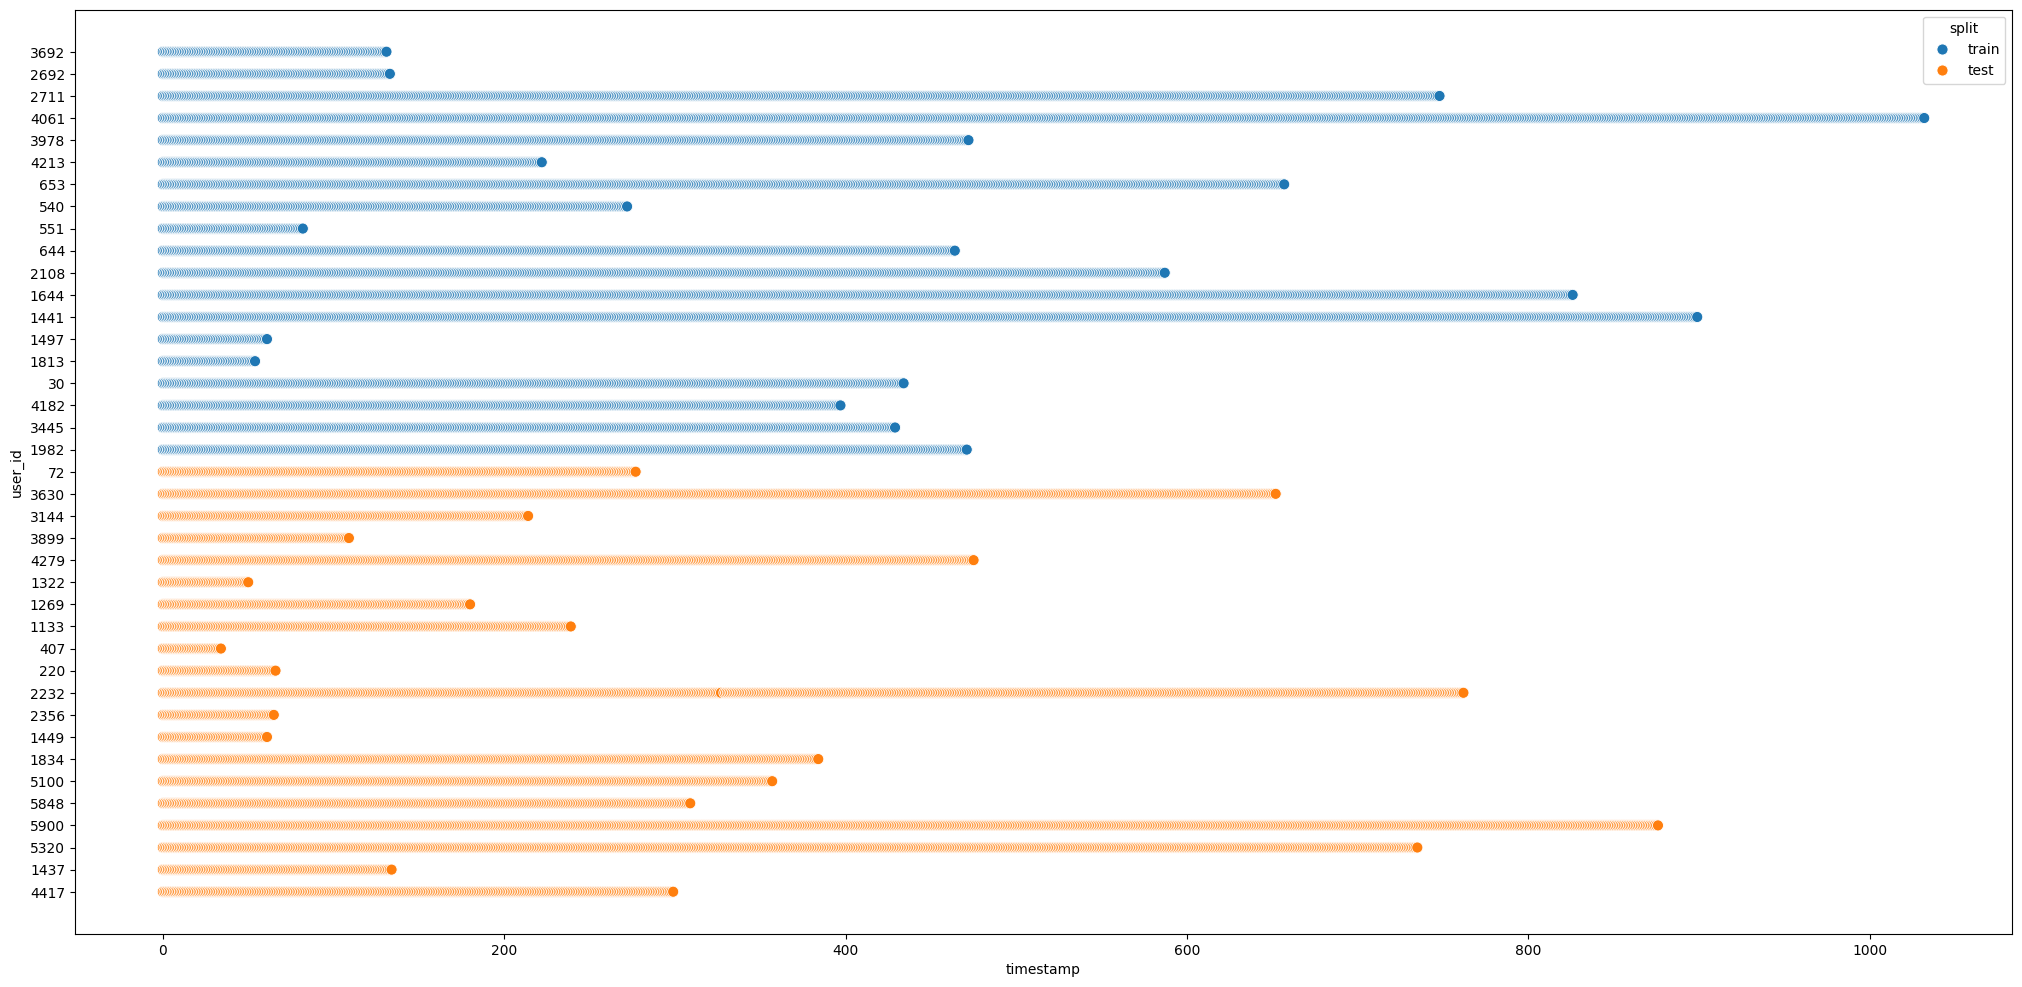

In [7]:
new_user_splitter = ColdUserRandomSplitter(
    test_size=0.1,
    drop_cold_items=True,
    query_column=user_col,
    item_column=item_col,
    seed=random_state
)
train_events, test_events = new_user_splitter.split(events)
print('Global Train',end=': ')
get_df_info(train_events)
print('Global Test',end=': ')
get_df_info(test_events)
print('Доля пересечения по users:', np.intersect1d(train_events[user_col].unique(),test_events[user_col].unique()).shape[0] / events[user_col].nunique())
print('Доля пересечения по items:', np.intersect1d(train_events[item_col].unique(),test_events[item_col].unique()).shape[0] / test_events[item_col].nunique())

train_sample_users = train_events[user_col].sample(20)
test_sample_users = test_events[user_col].sample(20)
show_train_test(train_events.loc[train_events[user_col].isin(train_sample_users)],
                test_events.loc[test_events[user_col].isin(test_sample_users)])

# Этап разбиения данных 2

Train events: Total rows 799621, unique users: 5436, unique items: 3677
Val: Total rows 5435, unique users: 5435, unique items: 1815
Доля пересечения по users: 0.9998160412067697

Test events: Total rows 88476, unique users: 604, unique items: 3265
Test: Total rows 602, unique users: 602, unique items: 476
Доля пересечения по users: 0.9966887417218543


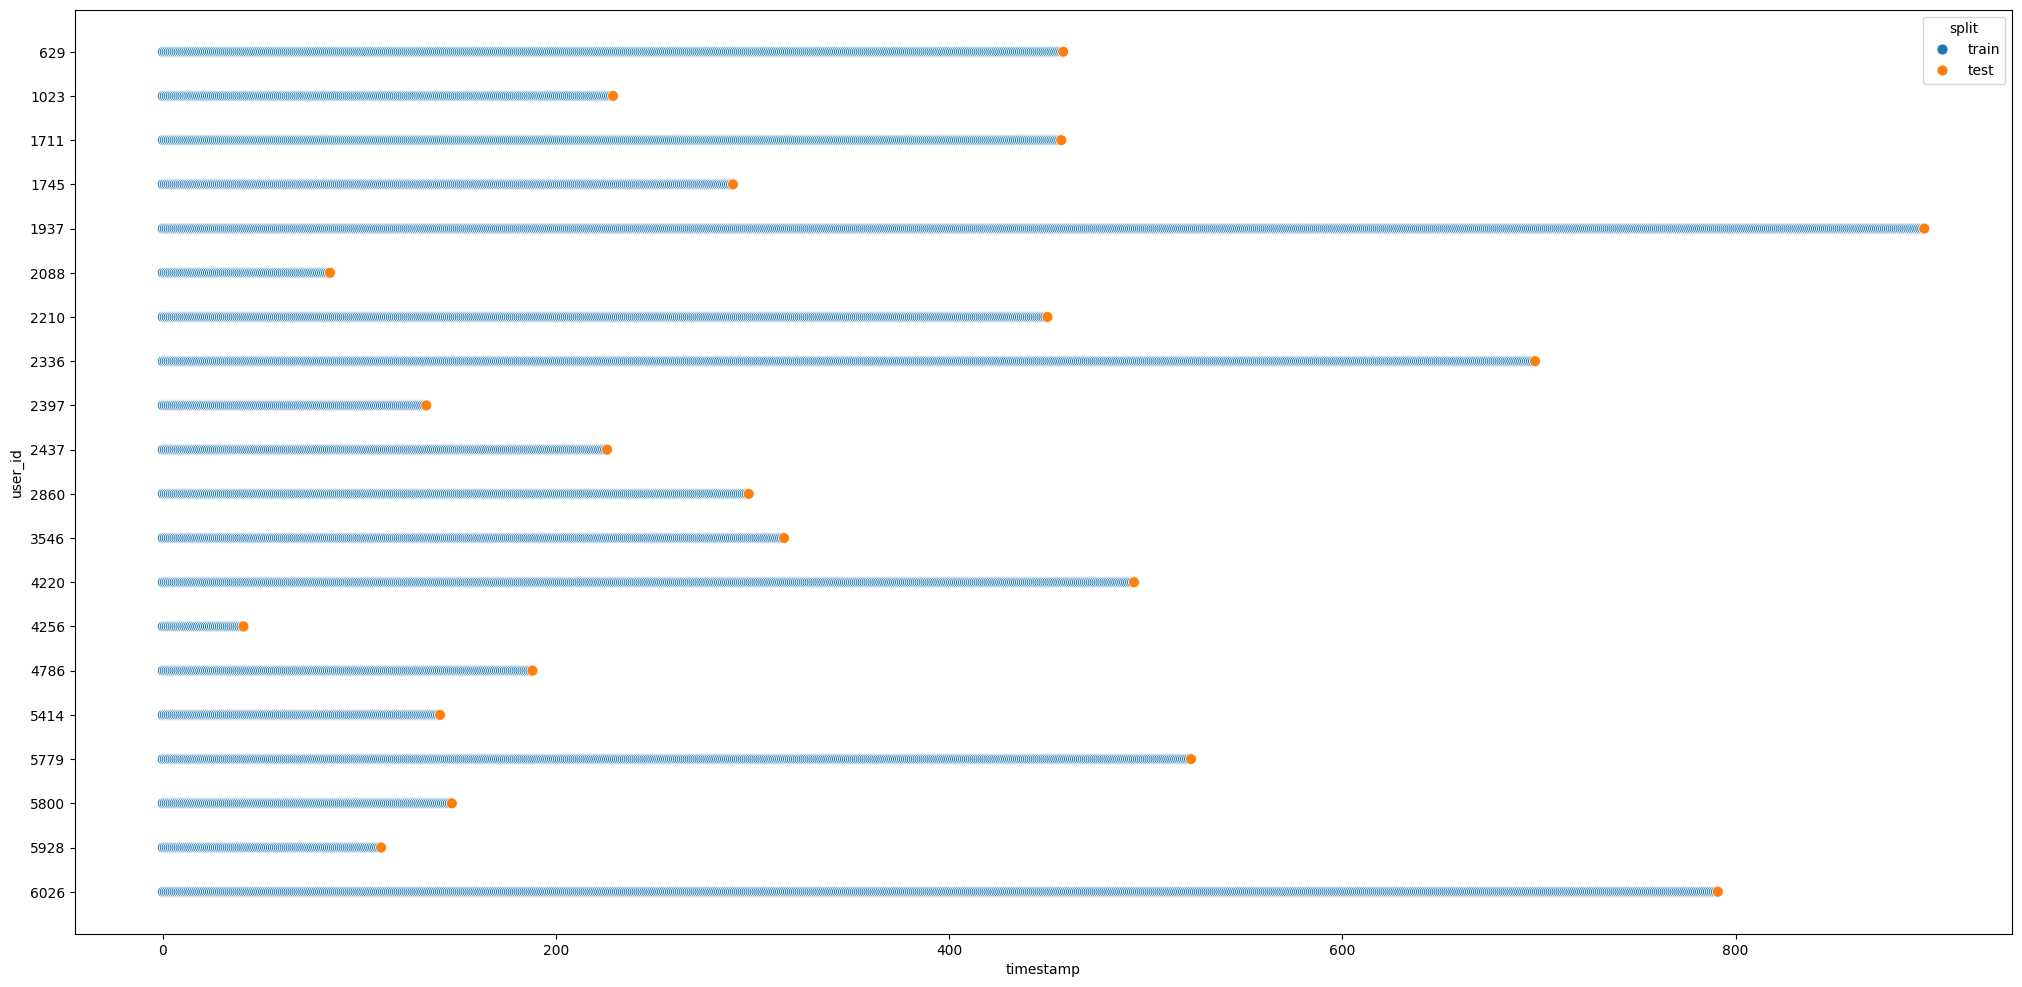

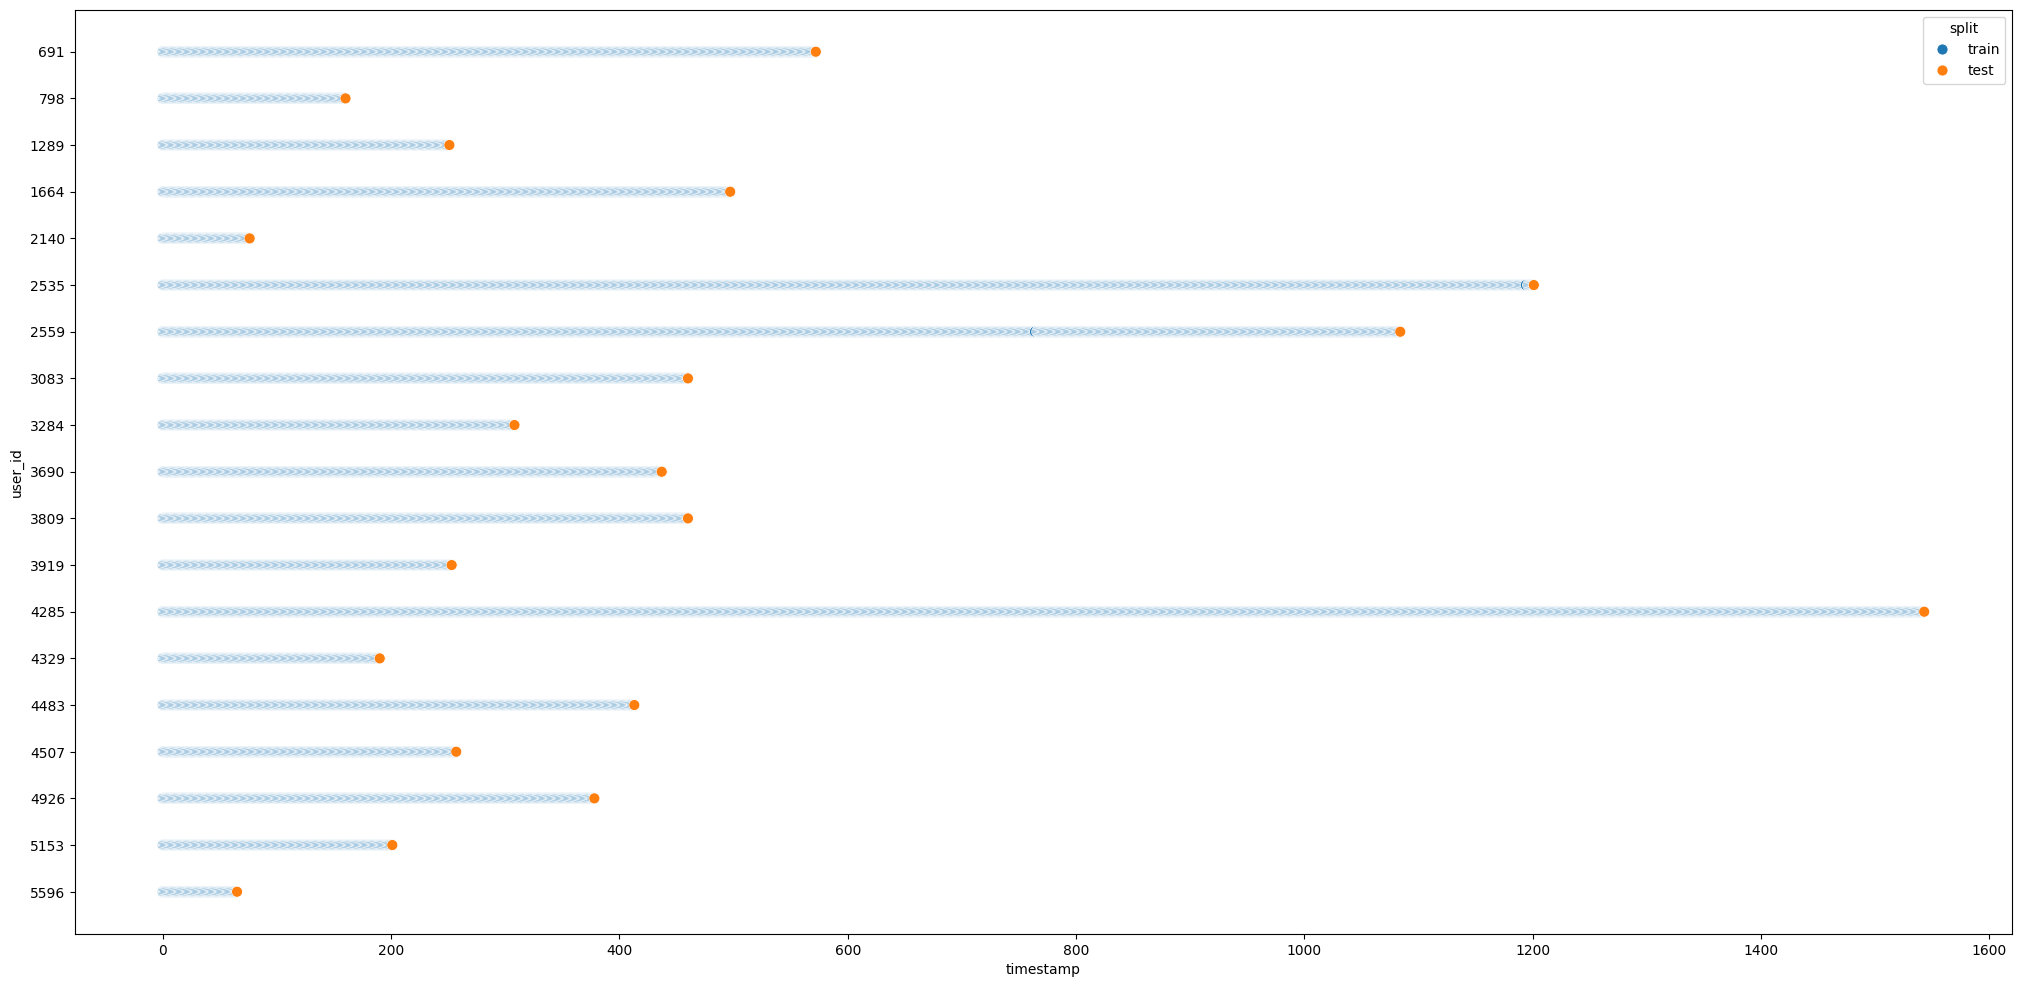

In [8]:
splitter = LastNSplitter(
    N=1,
    drop_cold_items=True,
    divide_column=user_col,
    strategy='interactions',
    query_column=user_col,
    item_column=item_col,
    timestamp_column=time_col
)

train_events, val = splitter.split(train_events)
test_events, test = splitter.split(test_events)
print('Train events', end=': ')
get_df_info(train_events)
print('Val', end=': ')
get_df_info(val)
print('Доля пересечения по users:', np.intersect1d(train_events[user_col].unique(),val[user_col].unique()).shape[0] / train_events[user_col].nunique())
print()
print('Test events', end=': ')
get_df_info(test_events)
print('Test', end=': ')
get_df_info(test)
print('Доля пересечения по users:', np.intersect1d(test_events[user_col].unique(),test[user_col].unique()).shape[0] / test_events[user_col].nunique())

train_sample_users = train_events[user_col].sample(20)
show_train_test(train_events.loc[train_events[user_col].isin(train_sample_users)],
                val.loc[val[user_col].isin(train_sample_users)])

test_sample_users = test_events[user_col].sample(20)
show_train_test(test_events.loc[test_events[user_col].isin(test_sample_users)],
                test.loc[test[user_col].isin(test_sample_users)])

# Второй вариант разбиения данных

In [9]:
splitter = LastNSplitter(
    N=1,
    divide_column=user_col,
    strategy='interactions',
    query_column=user_col,
    item_column=item_col,
    timestamp_column=time_col
)

raw_test_events, raw_test_gt = splitter.split(events)
raw_validation_events, raw_validation_gt = splitter.split(raw_test_events)
raw_train_events = raw_validation_events

print('Train events', end=': ')
get_df_info(raw_train_events)
print('Val', end=': ')
get_df_info(raw_validation_gt)
print('Test', end=': ')
get_df_info(raw_test_gt)

print('Доля пересечения по users:', np.intersect1d(raw_train_events[user_col].unique(),raw_test_gt[user_col].unique()).shape[0] / raw_test_gt[user_col].nunique())
print('Доля пересечения по items:', np.intersect1d(raw_train_events[item_col].unique(),raw_test_gt[item_col].unique()).shape[0] / raw_test_gt[item_col].nunique())

Train events: Total rows 882069, unique users: 6040, unique items: 3689
Val: Total rows 6040, unique users: 6040, unique items: 1876
Test: Total rows 6040, unique users: 6040, unique items: 1900
Доля пересечения по users: 1.0
Доля пересечения по items: 0.9994736842105263


# Создание энкодера user_id, item_id для моделей


In [10]:
# создадим spark сессию дефолтную так как данные небольшие
spark = State().session
spark.sparkContext.setLogLevel('ERROR')

events_spark = convert2spark(events)
total_user_count = events_spark.select(user_col).distinct().count()
total_item_count = events_spark.select(item_col).distinct().count()

feature_schema = FeatureSchema(
    [
        FeatureInfo(
            column=user_col,
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.QUERY_ID,
            cardinality=total_user_count,
        ),
        FeatureInfo(
            column=item_col,
            feature_type=FeatureType.CATEGORICAL,
            feature_hint=FeatureHint.ITEM_ID,
            cardinality=total_item_count,
        ),
        FeatureInfo(
            column=interaction_col,
            feature_type=FeatureType.NUMERICAL,
            feature_hint=FeatureHint.RATING,
        ),
        FeatureInfo(
            column=time_col,
            feature_type=FeatureType.NUMERICAL,
            feature_hint=FeatureHint.TIMESTAMP,
        ),
    ]
)

events_spark = Dataset(
    feature_schema=feature_schema,
    interactions=events_spark,
)

encoder = DatasetLabelEncoder()

encoder.fit(events_spark)

save_encoder(encoder, os.path.join(model_path,"encoder"))

# Сохранение выборок

In [11]:
raw_train_events.to_csv(os.path.join(data_path,'train.csv'),index=False)
raw_validation_gt.to_csv(os.path.join(data_path,'val.csv'),index=False)
raw_test_gt.to_csv(os.path.join(data_path,'test.csv'),index=False)